In [1]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp

from PointNet import PointNet
import numpy as np
import torch
from datasets.hitgraphs import HitGraphDatasetG
from datasets.graph import draw_sample_point
from torch_geometric.data import DataLoader
from torch_geometric.nn import fps, radius

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
model_fname = "tau_09aug/PointNet_1766657_71efe6edda_sitonga.eff0.9936.purity0.3556.20190809.150916.26.best.pth"

path = osp.join(osp.dirname(os.path.abspath('.')), '..', 'data', 'npz','partGun_PDGid15_x1000_Pt3.0To100.0_all')
full_dataset = HitGraphDatasetG(path)
fulllen = len(full_dataset)

d = full_dataset
num_classes = d[0].y.max().item() + 1 if d[0].y.dim() == 1 else d[0].y.size(1)
num_classes = int(num_classes)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = PointNet().to(device)
model.load_state_dict(torch.load(model_fname))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
evt_index = 3

test_dataset = torch.utils.data.Subset(full_dataset,[evt_index])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)




for i,data in enumerate(test_loader):
    assert (i == 0);
    x=(data.x.cpu().detach().numpy())
    pos =(data.pos.cpu().detach().numpy())
    y=(data.y.cpu().detach().numpy() >0.5)
    data = data.to(device)
    out = model(data).cpu().detach().numpy() > 0.5
    assert(y.shape == out.shape)
    


print(y)
print(out)

truepos = np.logical_and(y, out)
falseneg = np.logical_and(np.logical_not(out), y)
falsepos = np.logical_and(out, np.logical_not(y))
trueneg = np.logical_and(np.logical_not(y), np.logical_not(out))

assert(y.shape[0] == truepos.sum() + falseneg.sum() + falsepos.sum() + trueneg.sum())
print("truepos", truepos.sum(), "trueneg", trueneg.sum(), "falsepos", falsepos.sum(), "falseneg", falseneg.sum())

print("efficiency", truepos.sum()/y.sum())
print("purity", truepos.sum()/(truepos.sum()+falsepos.sum()))
print("reduction ratio", (truepos.sum()+falsepos.sum())/y.shape[0])

[ True  True  True ... False False False]
[ True  True  True ...  True  True  True]
truepos 922 trueneg 18225 falsepos 1216 falseneg 3
efficiency 0.9967567567567568
purity 0.431244153414406
reduction ratio 0.10497888637925955


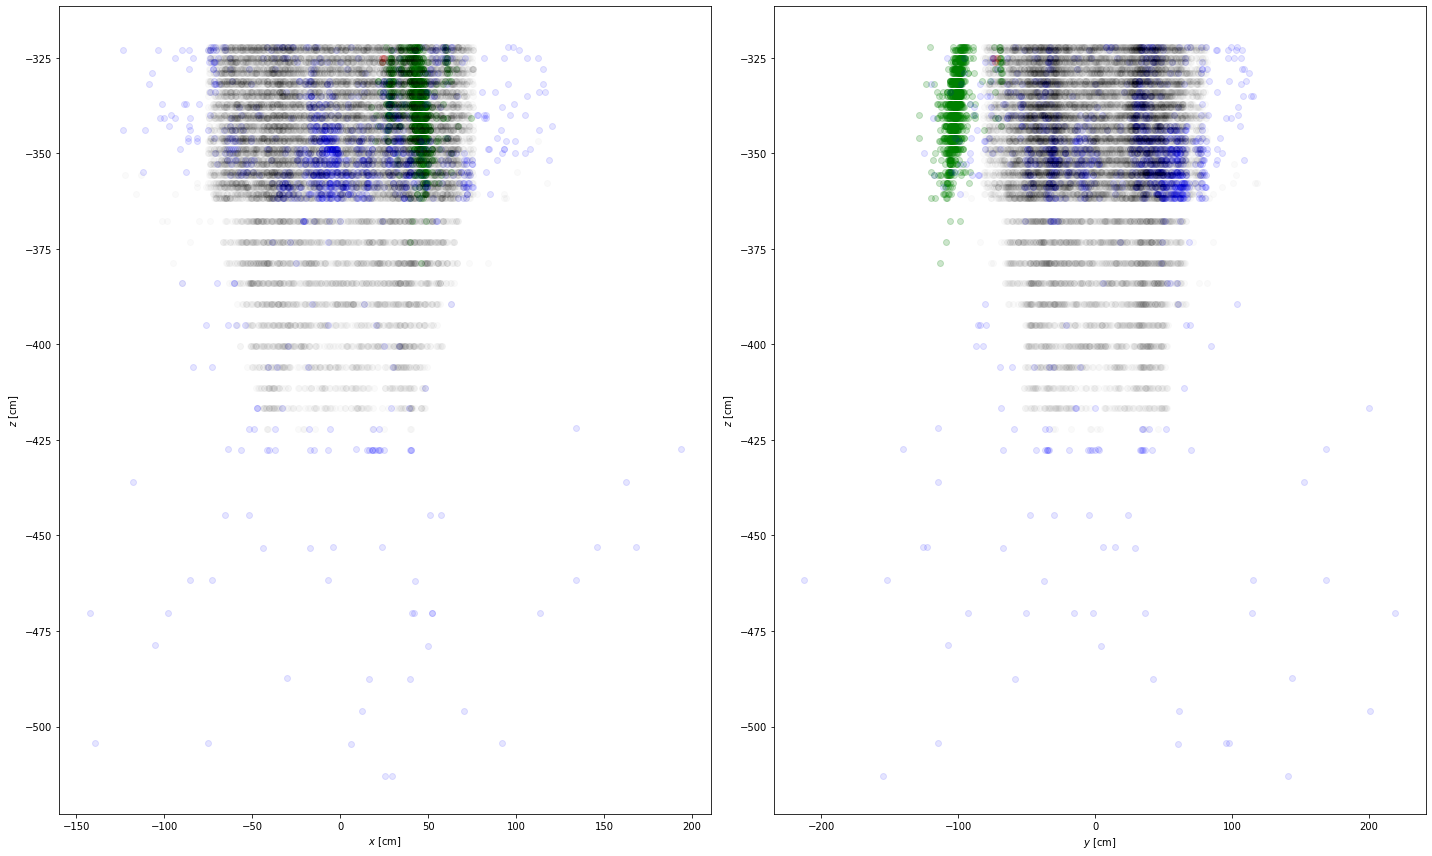

In [32]:
draw_sample_point(pos, y, out, truepos, trueneg, falsepos, falseneg);

In [ ]:
draw_sample_point(pos, y, out, truepos, trueneg, [], falseneg);

In [546]:
class TestSAModule(torch.nn.Module):
    def __init__(self, ratio, r):
        super(TestSAModule, self).__init__()
        self.ratio = ratio
        self.r = r

    def forward(self, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=64)
        edge_index = torch.stack([col, row], dim=0)
        pos = pos[idx]
        batch = batch[idx]
        return pos, batch, row, col, edge_index
    
class TestModel(torch.nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        #new
        self.sa1_module = TestSAModule(0.4, 4.0) #cluster size ~6, NN size 32
        self.sa2_module = TestSAModule(0.3, 7.0) #cluster size ~9, NN size 64
        self.sa3_module = TestSAModule(0.5, 14.0) #cluster size ~14, NN size 128
        
        #original
        #self.sa1_module = TestSAModule(0.4, 1.6) #cluster size ~6, NN size 32
        #self.sa2_module = TestSAModule(0.4, 3.5) #cluster size ~9, NN size 64
        #self.sa3_module = TestSAModule(0.4, 10.0) #cluster size ~14, NN size 128
        
    def forward(self, data):
        
        out1 = self.sa1_module(data.pos, data.batch)
        out2 = self.sa2_module(out1[0], out1[1])
        out3 = self.sa3_module(out2[0], out2[1])
        
        return out1, out2, out3

In [547]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
test_SAModule = TestModel().to(device)

In [548]:


howmany = 100
test_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=0,stop=howmany))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

y_l = []
first_covered_l =[]
first_sampled_l = []
first_eff = []
first_meanclustersize = []

second_covered_l = []
second_sampled_l = []
second_eff = []
second_meanclustersize = []

third_covered_l = []
third_sampled_l = []
third_eff = []
third_meanclustersize = []

t = tqdm.tqdm(enumerate(test_loader), total = howmany)
for i,data in t:
    #assert (i == 0);
    data = data.to(device)
    y = list(data.y.size())[0]
    y_l.append(y)
    output = test_SAModule(data)

    #first layer efficiency
    first_edge_index = output[0][4].cpu().detach().numpy()
    first_covered = np.unique(first_edge_index.flatten()).shape[0]
    first_covered_l.append(first_covered)
    first_sampled = list(output[0][0].size())[0]
    first_sampled_l.append(first_sampled)
    first_eff.append(first_covered/y)
    first_meanclustersize.append(np.mean(np.unique(output[0][2].cpu().detach().numpy(), return_counts=True)[1]))

    
    second_edge_index = output[1][4].cpu().detach().numpy()
    second_covered = np.unique(second_edge_index.flatten()).shape[0]
    second_covered_l.append(second_covered)
    second_sampled = list(output[1][0].size())[0]
    second_sampled_l.append(second_sampled)
    second_eff.append(second_covered/first_sampled)
    second_meanclustersize.append(np.mean(np.unique(output[1][2].cpu().detach().numpy(), return_counts=True)[1]))
    
    third_edge_index = output[2][4].cpu().detach().numpy()
    third_covered = np.unique(third_edge_index.flatten()).shape[0]
    third_covered_l.append(third_covered)
    third_sampled = list(output[2][0].size())[0]
    third_sampled_l.append(third_sampled)
    third_eff.append(third_covered/second_sampled)
    third_meanclustersize.append(np.mean(np.unique(output[2][2].cpu().detach().numpy(), return_counts=True)[1]))








  0%|          | 0/100 [00:00<?, ?it/s]





  1%|          | 1/100 [00:00<00:50,  1.96it/s]





  2%|▏         | 2/100 [00:00<00:46,  2.10it/s]





  3%|▎         | 3/100 [00:01<00:41,  2.33it/s]





  4%|▍         | 4/100 [00:01<00:39,  2.45it/s]





  5%|▌         | 5/100 [00:01<00:36,  2.58it/s]





  6%|▌         | 6/100 [00:02<00:34,  2.72it/s]





  7%|▋         | 7/100 [00:02<00:34,  2.71it/s]





  8%|▊         | 8/100 [00:03<00:34,  2.64it/s]





  9%|▉         | 9/100 [00:03<00:33,  2.73it/s]





 10%|█         | 10/100 [00:03<00:32,  2.78it/s]





 11%|█         | 11/100 [00:04<00:31,  2.85it/s]





 12%|█▏        | 12/100 [00:04<00:30,  2.89it/s]





 13%|█▎        | 13/100 [00:04<00:29,  2.94it/s]





 14%|█▍        | 14/100 [00:05<00:29,  2.96it/s]





 15%|█▌        | 15/100 [00:05<00:28,  3.00it/s]





 16%|█▌        | 16/100 [00:05<00:27,  3.00it/s]





 17%|█▋        | 17/100 [00:06<00:27,  3.01it/s]





 18%|█▊        | 18/100 [00:06<00:27,  3

[6.337991949910554, 6.247729624094723, 5.35281998454803, 5.701640548481881, 5.366775081310983, 5.27324306898775, 5.709337168884095, 5.84782117859562, 5.620806209313971, 5.667286475765464, 5.365220709833355, 5.3988388236779, 5.331709193486344, 5.3854932792290136, 5.263252702007206, 5.358435641058094, 5.415219611848825, 5.366994759043845, 5.333503770931868, 5.339205923656325, 5.362392295995945, 5.433151093439363, 5.330316165221825, 5.312910560889338, 5.790751304769996, 5.812771607918879, 5.26325927828432, 5.208682210485637, 5.675041479023466, 5.392333292247011, 5.394664328657314, 5.364938521992648, 5.3372995991983965, 5.702925908447381, 5.289658698708935, 5.3767672907909825, 5.283502600941293, 5.608543078412391, 5.5764677163432195, 5.414040836904462, 5.8019464720194645, 5.743202416918429, 5.164064467388567, 5.474565679290088, 5.540068409479599, 5.366211560546128, 5.26161369193154, 5.476618262367708, 5.579855586831477, 5.47973713033954, 5.355618953113371, 5.351271890579062, 5.351949685534

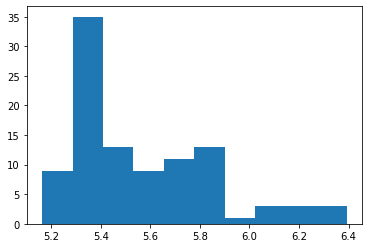

In [549]:
print(first_meanclustersize)
plt.hist(first_meanclustersize);

[1.0, 0.9997700726570403, 1.0, 0.9999020568070519, 1.0, 1.0, 0.9998561565017261, 0.9997741950051935, 0.9999499198717948, 0.999950411583854, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998540145985402, 0.9999033209261855, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999049881235155, 1.0, 1.0, 0.9999520038396928, 0.9997263023446766, 1.0, 0.9998551634239367, 0.9999048298834166, 0.9998572991485516, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999509803921569, 0.9992857142857143, 0.9998107404778803, 0.9996853083977701, 0.9996326061997703, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998179915366064, 0.9998137542487312, 0.999955779605554, 0.9999010635666584, 1.0, 1.0]


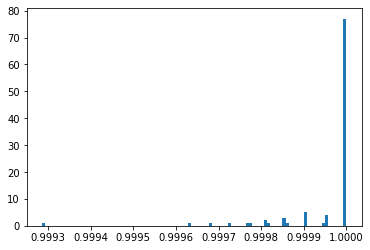

In [550]:
print(first_eff)
plt.hist(first_eff, bins=100);

[8.95193740685544, 9.08199233716475, 7.837339055793992, 8.381476948184414, 7.63651521467278, 7.684142672969489, 8.164602477027566, 8.253197893152747, 8.244889445139759, 8.325485336637753, 7.991097922848665, 7.912074042911232, 7.772222222222222, 7.803465765004226, 7.818610634648371, 7.969633066216786, 7.910212765957446, 7.902854708138048, 7.91947166595654, 7.846808510638298, 7.659206081081081, 7.9432712215320915, 7.831775700934579, 7.761263157894737, 8.457119741100323, 8.353580048270313, 7.727000427899016, 7.689136968656076, 7.955766192733018, 7.69227608874281, 7.744991652754591, 7.76425855513308, 7.663188647746244, 8.000393236335038, 7.787814230933106, 7.950764006791172, 7.400742880726372, 7.824193548387097, 8.076078112286412, 8.039059218815623, 8.35198702351987, 8.131292790978655, 7.529164918170373, 7.914202415660141, 7.835504885993485, 7.883078231292517, 7.807890222984563, 7.745693191140279, 8.110522022838499, 7.763990267639903, 7.658536585365853, 7.764806135492117, 7.663731656184487

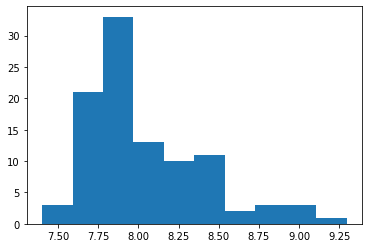

In [551]:
print(second_meanclustersize)
plt.hist(second_meanclustersize);

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


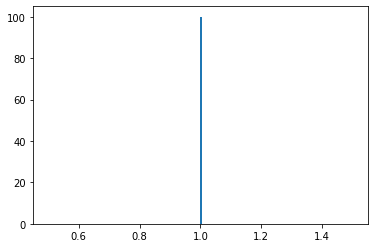

In [552]:
print(second_eff)
plt.hist(second_eff, bins=200);

[14.321907600596125, 14.780076628352491, 12.169957081545064, 13.689233278955955, 11.9475, 12.358247422680412, 12.84185303514377, 13.050413844996237, 13.321934945788156, 13.650701899256813, 12.58135593220339, 12.576114381833474, 12.412820512820513, 12.602704987320372, 12.39794168096055, 12.750421585160202, 12.879148936170212, 12.843270868824531, 12.982112436115843, 12.662978723404255, 11.923141891891891, 12.59519867549669, 12.422259983007647, 12.609427609427609, 13.466828478964402, 13.716814159292035, 12.429426860564584, 12.247210300429185, 12.407582938388625, 12.05341002465078, 12.151919866444073, 12.425675675675675, 12.14440734557596, 12.564465408805031, 12.183986371379898, 12.64685908319185, 11.430693069306932, 12.137096774193548, 13.072416598860862, 13.172963895885811, 13.856447688564478, 13.140901771336553, 11.724832214765101, 12.835137385512073, 12.401465798045603, 12.693877551020408, 12.356775300171526, 12.018047579983593, 13.234094616639478, 12.38199513381995, 12.008264462809917

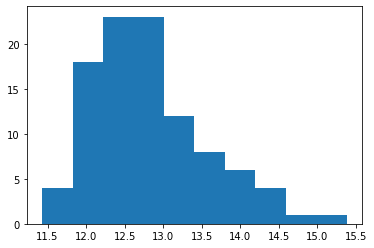

In [553]:
print(third_meanclustersize)
plt.hist(third_meanclustersize);

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


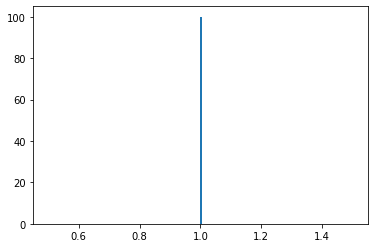

In [554]:
print(third_eff)
plt.hist(third_eff, bins=200);

In [555]:
third_sampled_l

[1342,
 1305,
 1165,
 1226,
 1200,
 1164,
 1252,
 1329,
 1199,
 1211,
 1180,
 1189,
 1170,
 1183,
 1166,
 1186,
 1175,
 1174,
 1174,
 1175,
 1184,
 1208,
 1177,
 1188,
 1236,
 1243,
 1169,
 1165,
 1266,
 1217,
 1198,
 1184,
 1198,
 1272,
 1174,
 1178,
 1212,
 1240,
 1229,
 1191,
 1233,
 1242,
 1192,
 1201,
 1228,
 1176,
 1166,
 1219,
 1226,
 1233,
 1210,
 1174,
 1193,
 1189,
 1262,
 1287,
 1247,
 1263,
 1343,
 1224,
 1251,
 1316,
 1175,
 1243,
 1261,
 1262,
 1150,
 1247,
 1284,
 1164,
 1221,
 1233,
 1189,
 1193,
 1236,
 1166,
 1186,
 1211,
 1217,
 1224,
 1344,
 1269,
 1335,
 1307,
 1190,
 1224,
 1211,
 1203,
 1172,
 1191,
 1241,
 1166,
 1158,
 1180,
 1319,
 1289,
 1357,
 1213,
 1198,
 1171]

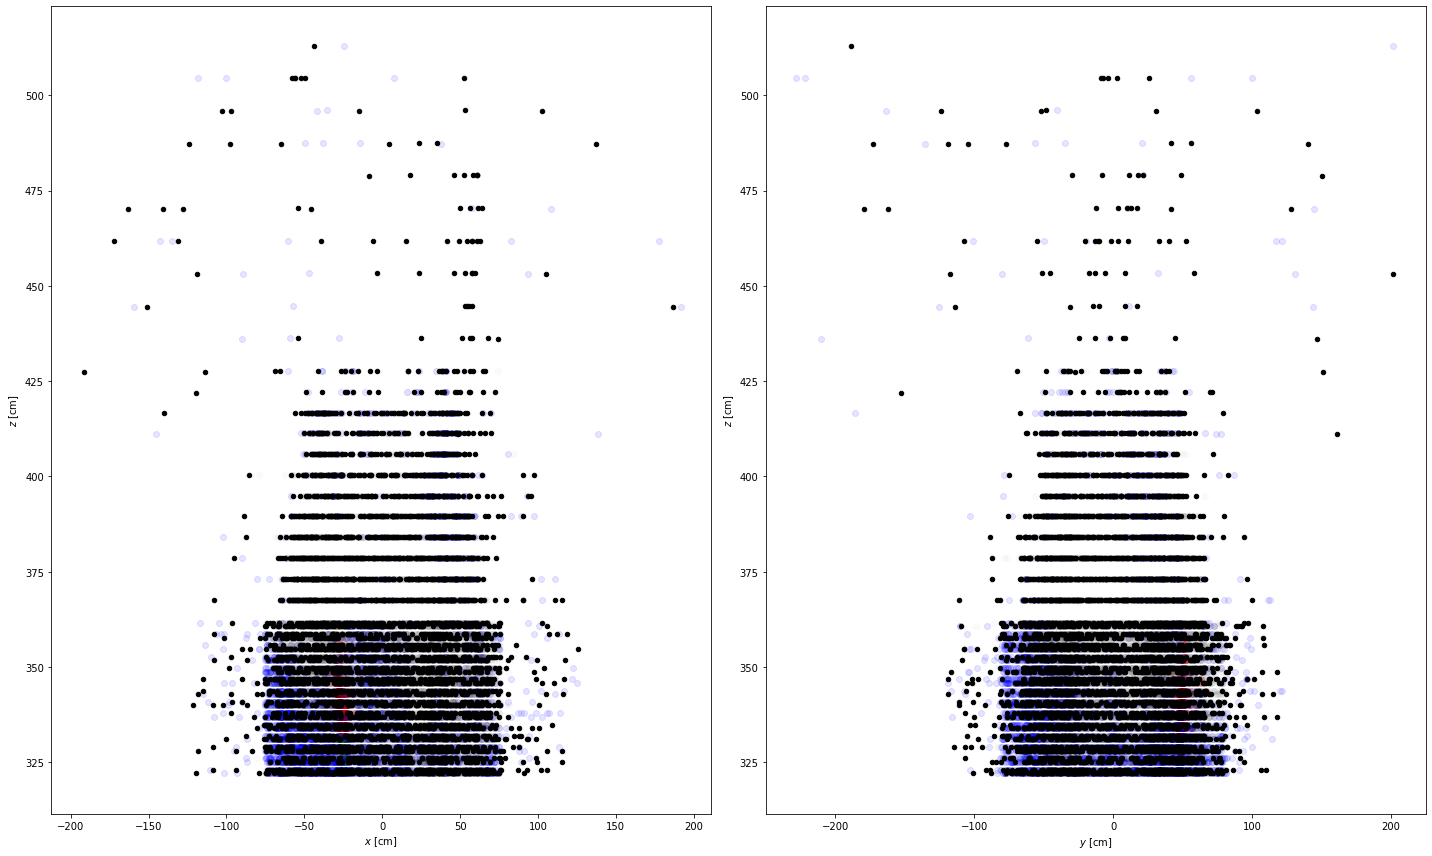

In [203]:
draw_sample_point(pos, y, out, truepos, trueneg, falsepos, falseneg, sampled=fout);